In [0]:
import zipfile
import requests
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
from scipy.special import expit
import scipy.misc
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(
    style='ticks',
    context='talk'
)
import pandas as pd 
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep
import keras

In [0]:
link = "https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip"
file_name = "./data/Dataset.zip"
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists(file_name):
    with open(file_name, "wb") as f:
            print ("Downloading %s" % file_name)
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                    sys.stdout.flush()

In [0]:
destination = 'data/sign-lang'
if not os.path.exists(destination):
    zip_ref = zipfile.ZipFile(file_name, 'r')
    zip_ref.extractall(destination)
    zip_ref.close()
path = './data/sign-lang/Dataset/'

In [0]:
# create dataframe containing all the 7 csv files
df = pd.DataFrame()
for user in os.listdir(path):
    df = df.append(pd.read_csv(path + user+"/"+user+"_loc.csv"))
    




In [240]:
df.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_10/A0.jpg,186,84,286,184
1,user_10/A1.jpg,186,84,286,184
2,user_10/A2.jpg,185,90,285,190
3,user_10/A3.jpg,180,88,290,198
4,user_10/A4.jpg,173,102,293,222


In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import glob
cropped = []
i = 0
for img in df["image"]:
    temp = image.load_img(path+img).crop(tuple(df.iloc[i,1:])).resize((240,320))
    cropped.append(img_to_array(temp))
    i += 1


In [0]:
X = np.array(cropped)

In [0]:
Y = np.array([p.split("/")[1][0] for p in df["image"]])

In [0]:
nshapes =len(np.unique(Y))

In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y)

In [246]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=33)
print("Train set size: {0},  Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 1344,  Test set size: 336


In [0]:
X_train = X_train/255
X_test = X_test/255

In [0]:
model = keras.models.Sequential()

model.add(
    keras.layers.Conv2D(32, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Conv2D(64, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Conv2D(64, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.Dropout(0.5))

model.add(
    keras.layers.Dense(nshapes))
model.add(
    keras.layers.Softmax())

In [0]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), 
    metrics=[keras.metrics.categorical_accuracy]
)

In [250]:
history = model.fit(x=X_train, y=y_train, batch_size=50, epochs=40,validation_data=(X_test, y_test)).history

Train on 1344 samples, validate on 336 samples
Epoch 1/40
1344/1344 [==============================] - 12s 9ms/step - loss: 3.3882 - categorical_accuracy: 0.0841 - val_loss: 2.5447 - val_categorical_accuracy: 0.3036
Epoch 2/40
1344/1344 [==============================] - 9s 7ms/step - loss: 1.9408 - categorical_accuracy: 0.4167 - val_loss: 1.3782 - val_categorical_accuracy: 0.5268
Epoch 3/40
1344/1344 [==============================] - 9s 7ms/step - loss: 1.0540 - categorical_accuracy: 0.6577 - val_loss: 0.8809 - val_categorical_accuracy: 0.7440
Epoch 4/40
1344/1344 [==============================] - 9s 7ms/step - loss: 0.6511 - categorical_accuracy: 0.7894 - val_loss: 0.7330 - val_categorical_accuracy: 0.7976
Epoch 5/40
1344/1344 [==============================] - 10s 7ms/step - loss: 0.4441 - categorical_accuracy: 0.8631 - val_loss: 0.8011 - val_categorical_accuracy: 0.7679
Epoch 6/40
1344/1344 [==============================] - 10s 7ms/step - loss: 0.2732 - categorical_accuracy: 0.9

In [261]:
print("accuracy on the test set:",history["val_categorical_accuracy"][-1])

accuracy on the test set: 0.8303571343421936


In [0]:
import random
j = random.randint(0,X_test.shape[0])
vis_x=X_test[j:j+9,:,:,:]
vis_y= y_test[j:j+9,:]
prediction = model.predict(vis_x)
pred_encoded = encoder.inverse_transform(prediction)
actual_encoded = encoder.inverse_transform(vis_y)

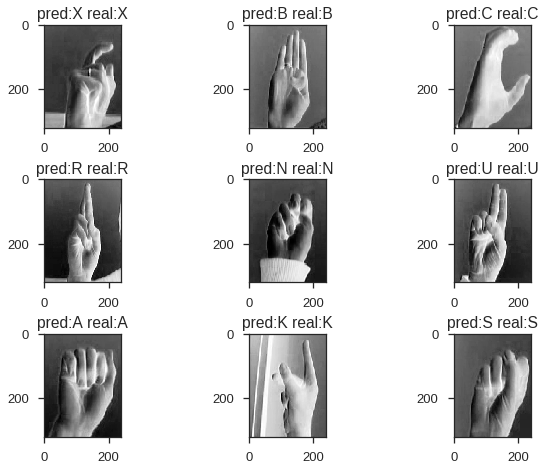

In [253]:
left  = 0.125  
right = 0.9    
bottom = 0.1  
top = 0.9      
wspace = 0.2   
hspace = 0.5 
               
plt.figure(1)
for i in range(0,9):
  plt.subplot(331+i)
  plt.imshow(vis_x[i,:,:,2])
  plt.title("pred:{} real:{}".format(pred_encoded[i],actual_encoded[i]))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.show()


In [0]:
y_pred = model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred)
Y_test = encoder.inverse_transform(y_test)

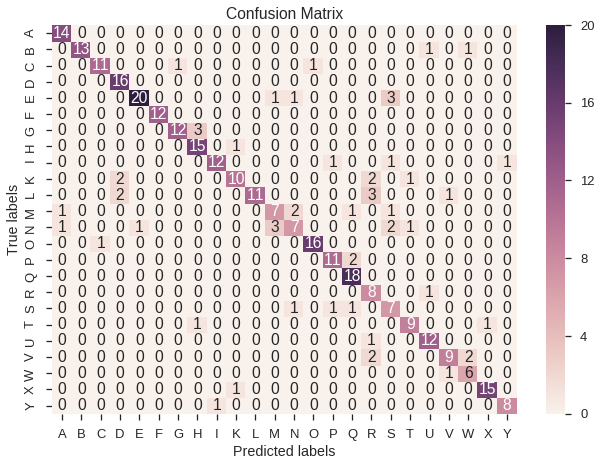

In [260]:
from sklearn.metrics import confusion_matrix

labels = ['A', 'B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
cm = confusion_matrix(Y_test, y_pred, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels[::-1]);